# CS 4100 Homework 05: Reinforcement Learning 

#### Due Monday  4/17 at midnight (1 minute after 11:59 pm) in Gradescope (with a grace period of 6 hours)
#### You may submit the homework up to 24 hours late (with the same grace period) for a penalty of 10%. 

You must submit the homework in Gradescope as a zip file containing <b>two files:</b>
- The <code>.ipynb</code> file (be sure to <code>Kernel -> Restart and Run All</code> before you submit); and
- A <code>.pdf</code> file of the notebook. 

For best results obtaining a clean PDF file on the Mac, select <code>File -> Print Review</code> from the Jupyter window, then choose <code>File-> Print</code> in your browser and then <code>Save as PDF</code>.  Something  similar should be possible on a Windows machine. 

All homeworks will be scored with a maximum of 100 points; if point values are not given for individual
problems, then all problems will be counted equally. 
 

In [1]:
# Imports 

import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random, randint, choice, normal,rand,seed
from scipy.stats import multivariate_normal
from collections import defaultdict
import sys
from tqdm import tqdm


## Problems One -- Five: Iterated Prisoner's Dilemma (50 points total)

In the first half of the homework, we will develop an experimental framework for investigating
the Iterated Prisoner's Dilemma. Please watch the lecture video for details of the IPD.

We will test two different frameworks, one where each agent in the population only plays against the agents in the environment, and so the agents are simply searching for the best strategy in that environment.
In the second set of experiments, we will have the population play against the environment, and also each other; in this way, the population can learn as a whole how to (perhaps) cooperate with each other to succeed
in that environment. 

An agent is a list of 6 numbers, the first an integer recording the cumulative rewards, and the rest
floats giving the probability P(C) of cooperating in the next round of a PD game, given the history
of what happened last time in the game with this player (e.g., CD means "I cooperated last time, you defected
last time" etc.)

     [rewards-so-far,  P(C) first time,  P(C) if CC last time, P(C) if CD, P(C) if DC, P(C) if DD  ] 

Two examples are given at the end of the next cell, which you should read carefully. 
But do not change anything unless you check with Prof Snyder. 

In [2]:
# Code for making environments


# Strategies as described above. First element is cumulative rewards, but is not used for
# environment agents, but provided as 0 for consistency with agents in population. 

Angel     = [0,1.0,1.0,1.0,1.0,1.0] # AN
Devil     = [0,0.0,0.0,0.0,0.0,0.0] # DE
ExplTFT   = [0,1.0,1.0,0.0,0.0,0.0] # EX
Pavlov    = [0,0.5,1.0,0.0,0.0,1.0] # PA
# Random will be created at runtime  #RA
TFT       = [0,1.0,1.0,0.0,1.0,0.0] # TF
Trickster = [0,1.0,0.0,0.0,0.0,0.0] # TR

# To make agents, be sure to make a copy each time, else will share the same list

def make_random_agent():
    return [0,0.5,0.5,0.5,0.5,0.5].copy()

def print_agent(A):    
    A = np.around(A,3)
    print("\nFirst move:",A[1],'\n')    
    print("      C       D")
    print('  -----------------')
    print('  |       |       | ')
    print('C | '+f"{A[2]:{5}}"+ ' | '+f"{A[3]:{5}}"+ ' | ')
    print('  |       |       | ')
    print('  -----------------')
    print('  |       |       | ')
    print('D | '+f"{A[4]:{5}}"+ ' | '+f"{A[5]:{5}}"+ ' | ')
    print('  |       |       | ')
    print('  -----------------')
    print("\nReward:",A[0])
    
def print_population(P):
    for A in P:
        print(list(np.around(A,3)))
    print()
    
# Environment is collection chosen from the above list

# makeup is list of how many of each, in order:
#           [ AN, DE, EX, PA, RA, TF, TR ]


def make_environment(makeup):
    (AN,DE,EX,PA,RA,TF,TR) = makeup
    Env =   [Angel]     * AN \
          + [Devil]     * DE \
          + [ExplTFT]   * EX \
          + [Pavlov]    * PA \
          + [ make_random_agent() for k in range(RA)]\
          + [TFT]       * TF \
          + [Trickster] * TR


    return Env

# create standard environments -- all have 10 agents. Could change this by changing the multiplier

m = 1      # multiplier

#                                      AN  DE  EX  PA  RA  TF  TR
All_Angels_Env     = make_environment( [10*m,  0,  0,  0,  0,  0,  0 ] )
All_Devils_Env     = make_environment( [ 0, 10*m,  0,  0,  0,  0,  0 ] )
All_ExplTFTs_Env   = make_environment( [ 0,  0, 10*m,  0,  0,  0,  0 ] )
All_Pavlovs_Env    = make_environment( [ 0,  0,  0, 10*m,  0,  0,  0 ] )
Random_Env         = make_environment( [ 0,  0,  0,  0, 10*m,  0,  0 ] )
All_TFTs_Env       = make_environment( [ 0,  0,  0,  0,  0, 10*m,  0 ] )
All_Tricksters_Env = make_environment( [ 0,  0,  0,  0,  0,  0, 10*m ] )
Mixed_Env          = make_environment( [ 2*m,  1*m,  1*m,  1*m,  1*m,  3*m,  1*m ] )

Environments = [All_Angels_Env,All_Devils_Env,All_ExplTFTs_Env,\
                All_Pavlovs_Env,Random_Env,All_TFTs_Env,All_Tricksters_Env,Mixed_Env]

Environments_labels = ['All_Angels_Env','All_Devils_Env','All_ExplTFTs_Env',\
                'All_Pavlovs_Env','Random_Env','All_TFTs_Env','All_Tricksters_Env','Mixed_Env']

print('Mixed_Env:')
print_population(Mixed_Env)

print("\nPavlov:", Pavlov)
print_agent(Pavlov)

print("\nTFT:", TFT)
print_agent(TFT)

Mixed_Env:
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.5, 1.0, 0.0, 0.0, 1.0]
[0.0, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


Pavlov: [0, 0.5, 1.0, 0.0, 0.0, 1.0]

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   1.0 |   0.0 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.0 |   1.0 | 
  |       |       | 
  -----------------

Reward: 0.0

TFT: [0, 1.0, 1.0, 0.0, 1.0, 0.0]

First move: 1.0 

      C       D
  -----------------
  |       |       | 
C |   1.0 |   0.0 | 
  |       |       | 
  -----------------
  |       |       | 
D |   1.0 |   0.0 | 
  |       |       | 
  -----------------

Reward: 0.0


## Problem One (10 pts)

The first task is to create offspring by mutation and crossover. Complete the following
template.  Sample test results can be viewed on the PDF version of the homework. 

Use `randint` to select the index to mutate. Use `normal(0,scale=mutate_std)` to choose a normally-distributed
offset with mean 0 and standard deviation `mutate_std`. Be sure to rectify the mutated probability
so that it is in the range 0..1. 

Hint: You can perform an action with probability p as follows:

    if random() < p:
         # do something with probability p
    else:
         # do something else with probability 1-p

In [3]:
# Reproduction

# force probability to be in range [0..1]

def rectify(x):
    if x>1:
        return 1
    elif x<0:
        return 0
    else:
        return x
    
# change randomly selected probability by normally-distributed offset 
# Must rectify to make sure is in range 0..1

def mutate(A,mutate_std):
    B = A.copy()                      # always make a copy so don't have two references to same data!
    ind = randint(1,5)
    B[ind] = rectify(B[ind] + normal(0,scale=mutate_std))
    return B

# crossover each probability of the strategies A and B by creating new agent C,
# and for each index 1..5, copy over from A with probability crossover_p and keep value
# from B with probability 1 - crossover_p. 

def crossover(A,B,crossover_p):
    C = B.copy()
    for i in range(1,6):
        if random() < crossover_p:
            C[i] = A[i]
    return C

# crossover and then mutate to create child, which is returned

def make_child(A,B,crossover_p=0.5,mutate_std=0.2):
    return mutate(crossover(A,B,crossover_p),mutate_std)

# test

seed(0)

print( mutate([0, 0,1.0,0.5,0.5,0.5], 0.1) )
print( crossover([0,1,1,1,1,1],[0,0,0,0,0,0],0.5) )
print( make_child([0,0.5,0.5,0.5,0.5,0.5],[0,0,0,0,0,0],0.5,0.2 ) )

[0, 0.11227949188291289, 1.0, 0.5, 0.5, 0.5]
[0, 0, 0, 0, 1, 1]
[0, 0.5, 0.5605610439106163, 0.5, 0, 0.5]


## Problem Two (10 pts)

The next task is to write code to play a game of `num_rounds` rounds between two players. 
The rewards should be calculated from the beginning of the game, but you should NOT change
the cumulative rewards at index 0 in the agents (these are the cumulative rewards). 

Hint:  When you want to determine what agent `A` should do the first time, `MoveIndex[('First','First')]`
will return `1`, which is the index where the probability of `C` the for the first move is stored in `A`. 
If this probability is `prob_c`, then

         choice( ['C','D'], p=[prob_c, 1-prob_c] )
         
will return `C` with probability `prob-c` and `D` with probability `1-prob_c`.  You must store
what each agent does, and then use it to look up the moves in the next round. You only need to
save the previous round. You must add together
the payoffs for all rounds to determine the rewards to return. 

In [4]:
# Set up Environment and Population

# Payoffs

payoffs = { ('C','C'):300, ('C','D'):-100, ('D','C'):500, ('D','D'):-10 }

# look up what index should be consulted for the first round, or for what happened
# last time after the first round. 

MoveIndex = { ('First','First'):1, ('C','C'):2, ('C','D'):3,\
                                     ('D','C'):4, ('D','D'):5    }

# play IPD between A and B and return reward for each of A and B at end of num_rounds rounds

def play_game(A,B,num_rounds):
    reward_A = reward_B = 0
    current = ['','']
    currRev = ['','']
    for i in range(num_rounds):
        if i == 0:
            if random() < A[MoveIndex[('First','First')]]:
                current[0] = 'C'
            else:
                current[0] = 'D'
            if random() < B[MoveIndex[('First','First')]]:
                current[1] = 'C'
            else:
                current[1] = 'D'
            currRev = current.copy()
            currRev.reverse()
            reward_A = reward_A + payoffs[tuple(current)]
            reward_B = reward_B + payoffs[tuple(currRev)]
        else:
            if random() < A[MoveIndex[tuple(current)]]:
                current[0] = 'C'
            else:
                current[0] = 'D'
            if random() < B[MoveIndex[tuple(currRev)]]:
                current[1] = 'C'
            else:
                current[1] = 'D'
            reward_A = reward_A + payoffs[tuple(current)]
            reward_B = reward_B + payoffs[tuple(currRev)]
            

    return (reward_A,reward_B)

# test

A = Angel
B = Devil
print(A)
print(B)
(ra,rb) = play_game(A,B,10)
print(ra,rb)
print()

# play IPD with every member of Env and return cumulative reward
def get_reward(A,Env,num_rounds):
    total_reward = 0
    for B in Env:
        total_reward = total_reward + play_game(A,B,num_rounds)[0]
    return total_reward         # your code here


# test

print(get_reward(Angel,All_Devils_Env,10))
print(get_reward(TFT,All_Angels_Env,10))

[0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 0.0, 0.0, 0.0, 0.0, 0.0]
-1000 5000

-10000
30000


This cell is used to display the results for analysis. Do not change anything without consultation. 

In [5]:
# Keep track of winner in each round

def record_parameters(A,Params):
    for k in range(len(Params)):
        Params[k].append(A[k])

# Display subplots of rewards and the strategy which evolved

def display_evolution(Params):
    print()
    titles = ['Payoff','First','CC','CD','DC','DD']
    fig = plt.figure(figsize=(12,10))
    ax1 = plt.subplot(211)
    fig.subplots_adjust(hspace=0.4)
    plt.title("Rewards")
    plt.grid(color='r',alpha=0.1)    # alpha sets the transparency, 0 = invisible and 1 = normal 
    plt.ylabel("Reward")
    plt.xlabel("Generations")
    plt.plot(Params[0])
 
    ax2 = plt.subplot(212, sharex=ax1)
    plt.title("Strategy as Probability of Cooperate")
    plt.grid(color='r',alpha=0.1)    # alpha sets the transparency, 0 = invisible and 1 = normal 
    plt.ylabel("Probability of C")
    plt.xlabel("Generations")
    plt.ylim(-0.1,1.1)
    for k in range(1,6):         
        plt.plot(Params[k],label=titles[k])
    plt.legend()
    plt.show()
    print()

    print("Best agent in last generation:")
    print_agent( [ Params[i][-1] for i in range(len(Params)) ] )    

## Problem Three  (15 pts)

The last task in creating the framework for experimenting with the IPD is to complete
the following template, and verify that it works as expected. Follow the pseudocode and
test as indicated (results may be found in the accompanying PDF). 

Hints:  You can sort a list of lists in descending order on the first elements as shown here:

          lst_of_lsts.sort(reverse=True, key=(lambda x: x[0])) 
          


Environment: All_Angels_Env
[40425200.0, 0.5, 0.5, 0.5, 0.5, 0.5]
[40425200.0, 0.5, 0.5, 0.5, 0.5, 0.5]
[40425200.0, 0.5, 0.5, 0.5, 0.5, 0.5]
[40425200.0, 0.5, 0.5, 0.5, 0.5, 0.5]
[40425200.0, 0.5, 0.5, 0.5, 0.5, 0.5]
[40425200.0, 0.5, 0.567, 0.5, 0.5, 0.5]
[40425200.0, 0.5, 0.5, 0.317, 0.5, 0.5]
[40425200.0, 0.483, 0.5, 0.5, 0.5, 0.5]
[40425200.0, 0.5, 0.516, 0.5, 0.5, 0.5]
[40425200.0, 0.374, 0.5, 0.5, 0.5, 0.5]




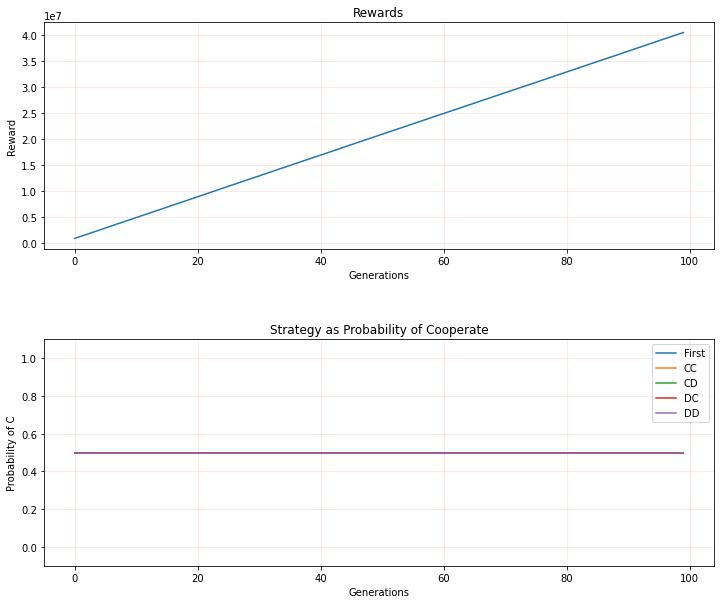


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 40425200.0


In [6]:
# Run an experiment


def run_experiment(environment,population_size,num_children,
                   num_generations,crossover_prob=0.5, mutate_std=0.1,
                   num_rounds=100, play_each_other=False, 
                   print_pop=False, display_evol=True):

    # make the population of random agents, which start with P(C) = 0.5 for all actions
    # use make_random_agent, which always provides a new copy of the array
    
    population = [make_random_agent()] * population_size

    # keep track of parameters for best agent in each generation

    #             Reward First  CC  CD  DC  DD
    parameters = [    [],   [], [], [], [], [] ]
    


    for k in range(num_generations):     

        # play each agent against the environment and insert the reward into A[0]
        # if play_each_other is True, then play against environment + population, 
        # else just play against evironment
        
        for A in population:
            A[0] = A[0] + get_reward(A,environment,num_rounds)
        
        if play_each_other:
            for A in population:
                pop_sans = population.copy()
                pop_sans.remove(A)
                A[0] = A[0] + get_reward(A,pop_sans,num_rounds)

        # sort the population in descending order of rewards from this generation
        
        population.sort(key=lambda a: -a[0])
        
        # record best agent
        record_parameters(population[0],parameters)    

        # generate children: delete the last num_children agents in population (those
        # with the worst rewards in this generation), use the remaining population
        # as parents to create num_children new children to add to the population. 
        # Select parents randomly from the remaining population. 
        # Use choice(...., replace=False) so you don't choose the same parent twice in one "birth". 
        
        population = population[:-num_children]
        pop_parents = population.copy()
        for c in range(num_children):
            vals = choice(len(pop_parents),2,replace=False)
            population.append(make_child(population[vals[0]],population[vals[1]],crossover_prob,mutate_std))
        

        
    # Display evolution of best agents
    if print_pop:
        print_population(population)
    if display_evol:    
        display_evolution(parameters)

# test
seed(0)
print("Environment: All_Angels_Env")
run_experiment(environment=Environments[0],
               population_size=10,
               num_children=5,
               num_generations=100,
               crossover_prob=0.5, 
               mutate_std=0.1,
               num_rounds=20,
               play_each_other=False,
               print_pop=True,
               display_evol=True)


## Problem Four  (7.5 pts)


Now the fun begins....  For this problem, we would like you to run multiple experiments to investigate
what strategies will evolve in each of the 8 environments defined in the first code cell above. 
Test things out with smaller numbers of generations and population size, but eventually you should run experiments with at least the following parameters:

    run_experiment(environment= ... ,
                   population_size=100,          # try with 10 to start, but best results with at least 100
                   num_children=50,              # this is 50% children, if change pop size also change this
                   num_generations=100,          # may need to change this depending on results
                   crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
                   mutate_std=0.1,               #     smaller values will make children more similar to parents
                   num_rounds=20,                # don't do less than 20
                   play_each_other=False,
                   print_pop=False,
                   display_evol=True)
                   
Your goal is to determine what strategy evolves in each of the environments. It may not correspond
to one of of the environment strategies, but you can examine the winning agent at the end
and think about the choices it learned to make. 

Feel free to change the parameters, as long as `play_each_other=False` and `num_rounds` is at least 20. 
In particular, you may see the strategy stabilize in fewer generations, or you may need to go above
100 to see the result. In general, you will get better results with larger populations. 

Run your experiments, and for each, give a short explanation of what you see, and why you think
that particular strategy evolved. It may not be possible to give a precise explanation, but give it
a shot!  **In particular, do you see an approximation of one of the "named strategies" (Angle, TFT, etc.) evolving
in response to an environment?**

Also explain if you found better choices of the other parameters such as percentage of
children, crossover probability, and the mutation standard deviation. I found good results
with the values above; these three essentially affect the learning rate, and hence the
rate at which it stabilizes. 



Environment: All_Devils_Env



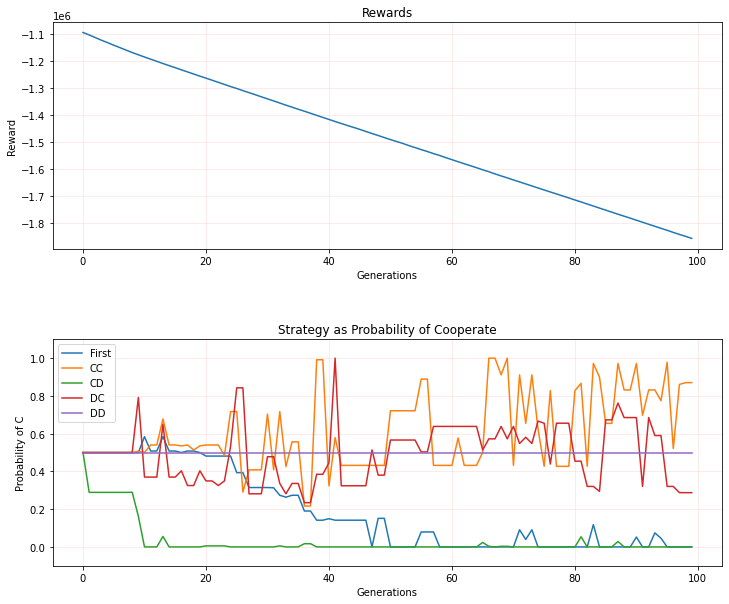


Best agent in last generation:

First move: 0.0 

      C       D
  -----------------
  |       |       | 
C |  0.87 |   0.0 | 
  |       |       | 
  -----------------
  |       |       | 
D | 0.287 |   0.5 | 
  |       |       | 
  -----------------

Reward: -1858070.0
Environment: All_ExplTFTs_Env



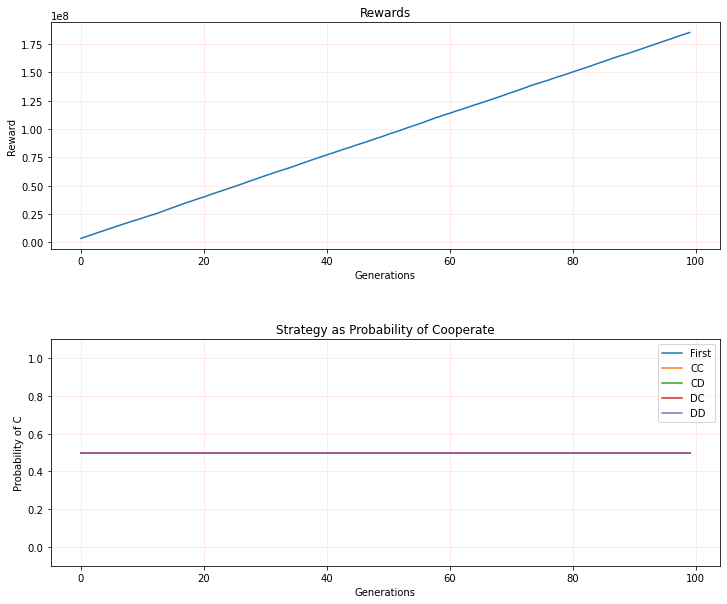


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 185107890.0
Environment: All_Pavlovs_Env



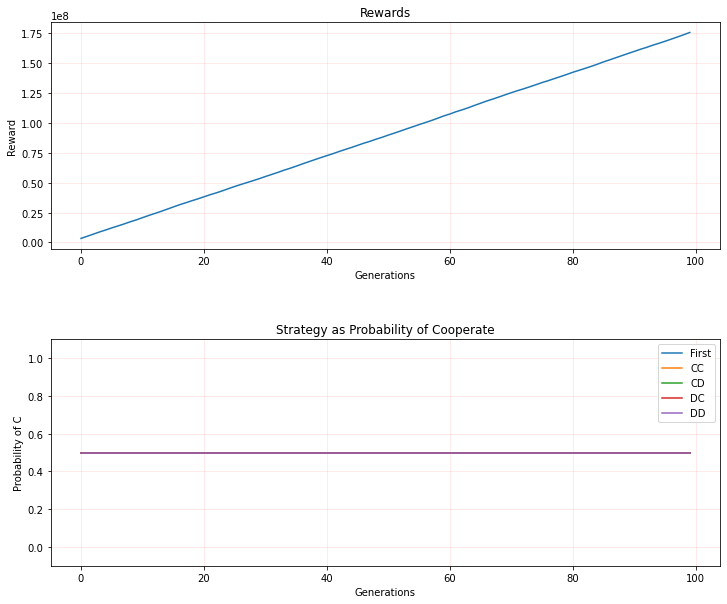


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 175779220.0
Environment: Random_Env



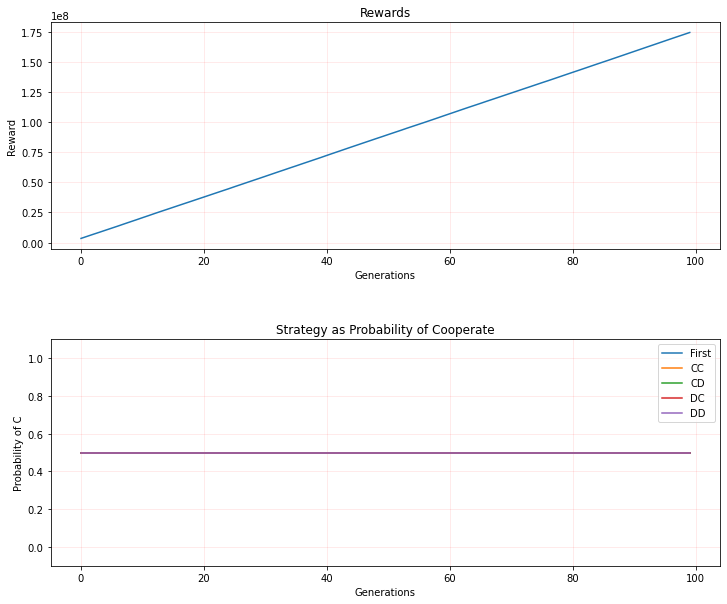


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 174368490.0
Environment: All_TFTs_Env



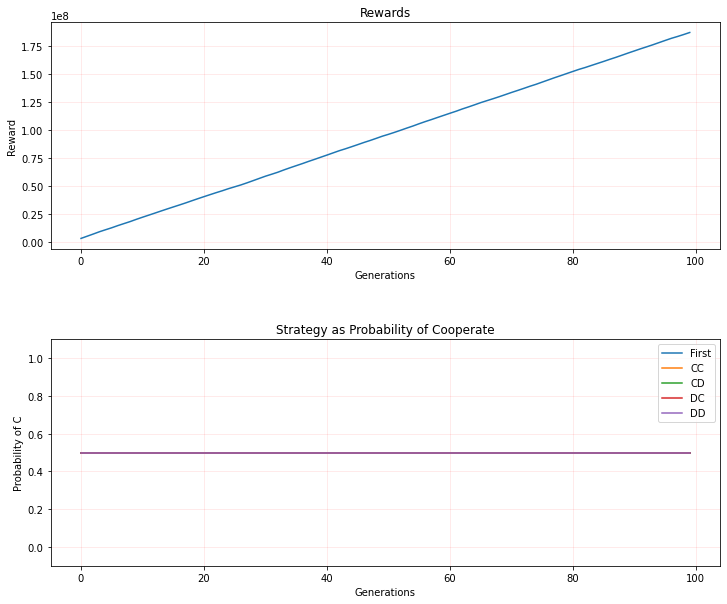


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 187084890.0
Environment: All_Tricksters_Env



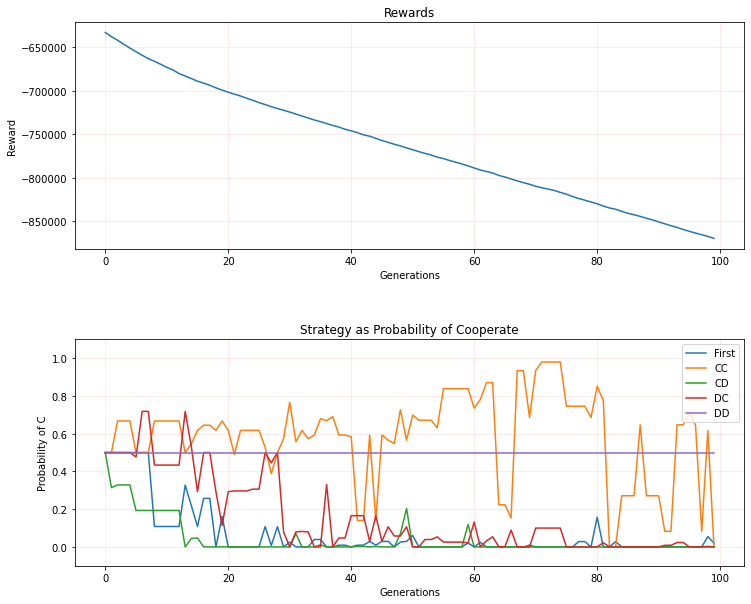


Best agent in last generation:

First move: 0.02 

      C       D
  -----------------
  |       |       | 
C |   0.0 |   0.0 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.0 |   0.5 | 
  |       |       | 
  -----------------

Reward: -869390.0
Environment: Mixed_Env



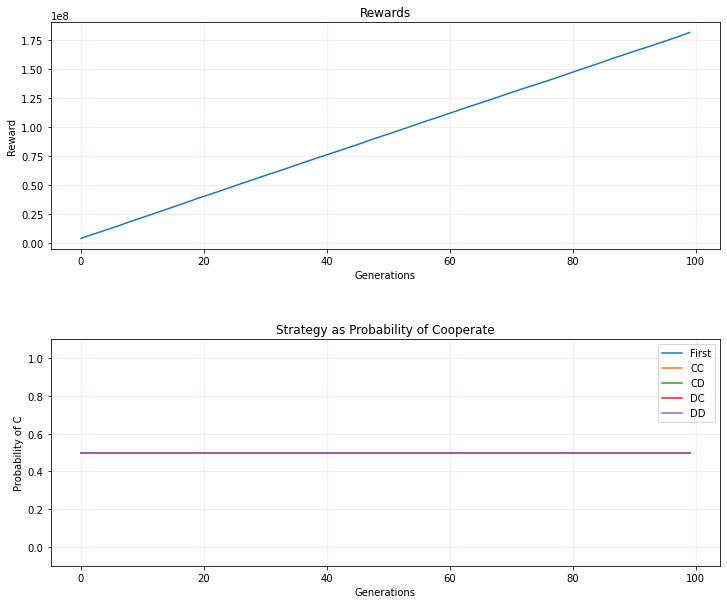


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 181866090.0


In [7]:
print("Environment: All_Devils_Env")
run_experiment(environment=Environments[1],
               population_size=100,          # try with 10 to start, but best results with at least 100
               num_children=50,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=False,
               print_pop=False,
               display_evol=True)
print("Environment: All_ExplTFTs_Env")
run_experiment(environment=Environments[2],
               population_size=100,          # try with 10 to start, but best results with at least 100
               num_children=50,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=False,
               print_pop=False,
               display_evol=True)
print("Environment: All_Pavlovs_Env")
run_experiment(environment=Environments[3],
               population_size=100,          # try with 10 to start, but best results with at least 100
               num_children=50,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=False,
               print_pop=False,
               display_evol=True)
print("Environment: Random_Env")
run_experiment(environment=Environments[4],
               population_size=100,          # try with 10 to start, but best results with at least 100
               num_children=50,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=False,
               print_pop=False,
               display_evol=True)
print("Environment: All_TFTs_Env")
run_experiment(environment=Environments[5],
               population_size=100,          # try with 10 to start, but best results with at least 100
               num_children=50,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=False,
               print_pop=False,
               display_evol=True)
print("Environment: All_Tricksters_Env")
run_experiment(environment=Environments[6],
               population_size=100,          # try with 10 to start, but best results with at least 100
               num_children=50,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=False,
               print_pop=False,
               display_evol=True)
print("Environment: Mixed_Env")
run_experiment(environment=Environments[7],
               population_size=100,          # try with 10 to start, but best results with at least 100
               num_children=50,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=False,
               print_pop=False,
               display_evol=True)

## Problem Five  (7.5 pts)


Now we would like you to do the same as in the last problem, but with `play_each_other=True` 
and with just the following environments:

         All_Devils_Env,    All_Pavlovs_Env,    All_TFTs_Env,      Mixed_Env
         
In general, you will need to run these for more than 100 generations to see a potential group strategy evolving. 
You may need to modify the other parameters as well. 

Since the size of the environment is 10 agents, one reasonable choice is to restrict the population
to the same size.  A better analysis could be gotten by increasing the environment to 100 agents, but
this would consume a great deal of  time. **Thus, use a population size of 10 for this problem.** 

Again, for each of these four environments, show your results and provide analysis for each case. 

Be sure to comment on how these may be different from the same environment in the previous problem. 

Environment: All_Devils_Env



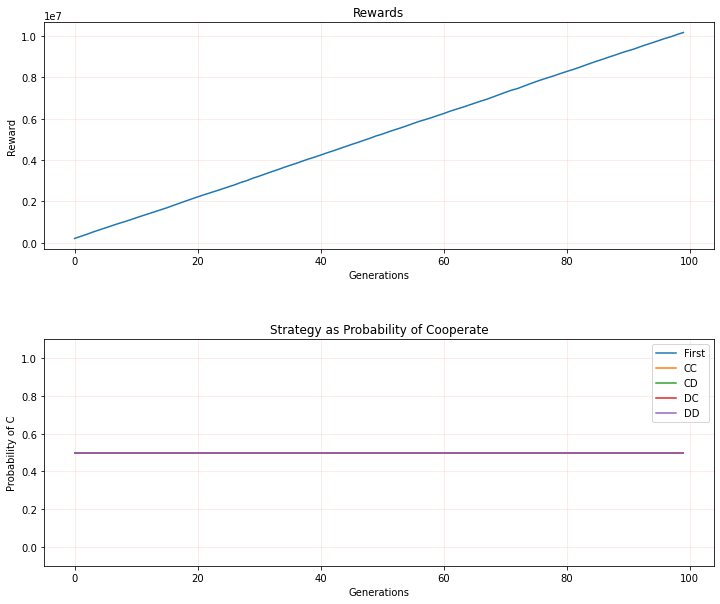


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 10168760.0
Environment: All_Pavlovs_Env



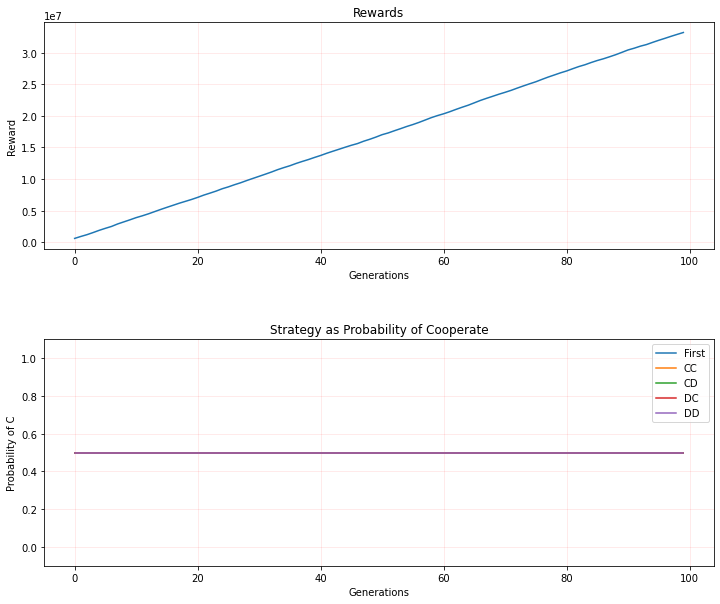


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 33189580.0
Environment: All_TFTs_Env



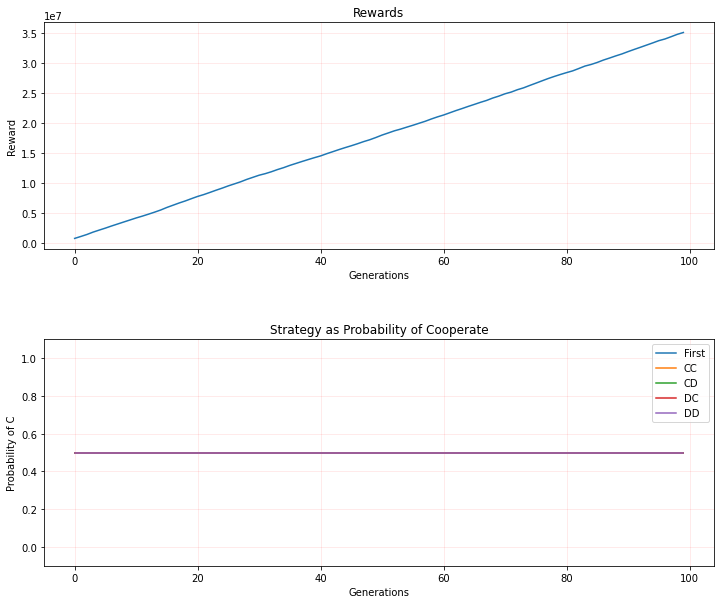


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 35021730.0
Environment: Mixed_Env



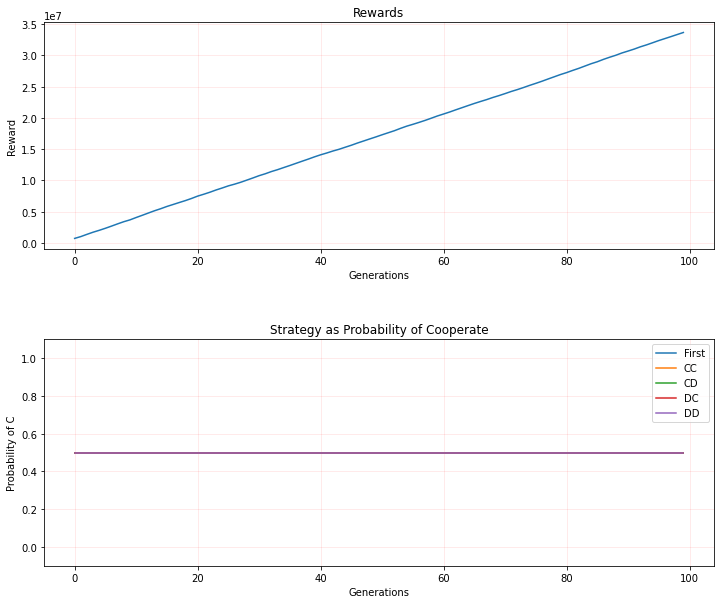


Best agent in last generation:

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   0.5 |   0.5 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.5 | 
  |       |       | 
  -----------------

Reward: 33650250.0


In [8]:
print("Environment: All_Devils_Env")
run_experiment(environment=Environments[1],
               population_size=10,          # try with 10 to start, but best results with at least 100
               num_children=5,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=True,
               print_pop=False,
               display_evol=True)
print("Environment: All_Pavlovs_Env")
run_experiment(environment=Environments[3],
               population_size=10,          # try with 10 to start, but best results with at least 100
               num_children=5,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=True,
               print_pop=False,
               display_evol=True)
print("Environment: All_TFTs_Env")
run_experiment(environment=Environments[5],
               population_size=10,          # try with 10 to start, but best results with at least 100
               num_children=5,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=True,
               print_pop=False,
               display_evol=True)
print("Environment: Mixed_Env")
run_experiment(environment=Environments[7],
               population_size=10,          # try with 10 to start, but best results with at least 100
               num_children=5,              # this is 50% children, if change pop size also change this
               num_generations=100,          # may need to change this depending on results
               crossover_prob=0.5,           # you can think of these two as similar to the learning rate:
               mutate_std=0.1,               #     smaller values will make children more similar to parents
               num_rounds=20,                # don't do less than 20
               play_each_other=True,
               print_pop=False,
               display_evol=True)

## Problems Six -- Ten: Q-Learning in Gridworld

For the rest of this homework, we will investigate Reinforcement Learning a Grid World, a simple
problem in which a single agent moves around a 2D grid in search of a goal state where
a reward sits waiting.  These are all versions of the cliff walking example shown in lecture. 

In general, it "costs" 1 unit to move, so that many cells may have an immediate reward of -1.
There are also "holes" where the game terminates and the immediate reward is -100.
The start state has a reward of 0 and the goal state has a reward of 100. The trial
terminates at holes and in the goal state. 

We have provided various functions to display the grid, the rewards, the Q-Table and the
strategy which evolves to garner the maximum cumulative reward at the end. 

The next two cells show how each world is created as an object with a grid of rewards, 
a start state, and terminal states (where the current trial will end). 

In [9]:
# Each grid world has a 2d matrix of rewards (which also gives the dimensions of the matrix),
# a start state, and a list of terminal states, where a trial will terminate


class GridWorld:
 
    # constructor
    def __init__(self, reward_grid, start_state, terminal_states):
        self.reward_grid = reward_grid
        self.terminal_states = terminal_states
        self.start_state = start_state
        self.num_rows = len(reward_grid)
        self.num_cols = len(reward_grid[0])
    
    # rewards in each state
    
    def R(self,state):
        (r,c) = state
        return self.reward_grid[r][c]
    
    # print out the rewards in text form
    
    def print_rewards(self):
        print("Rewards")
        width = 5
        hrule = ('-------'*self.num_cols)+'-'

        print(hrule)
        for r in range(self.num_rows):
            print('|',end='')
            for c in range(self.num_cols):  
                if (r,c) == self.start_state:
                    print(f"{0:{width}} |",end='')
                else:
                    print(f"{self.reward_grid[r][c]:{width}} |",end='')
            print('\n'+hrule)
    
    # Display the grid with colors and show the start and goal
    
    def display_heat_map(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title('Grid World')
        ax.xaxis.set_ticks(range(20))             # assumes that no more than 20 rows or columns
        ax.yaxis.set_ticks(range(20))
        for tick in ax.xaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)
        for tick in ax.yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)
        ax.imshow(self.reward_grid,extent=(0,self.num_cols,0,self.num_rows))
        (r,c) = self.start_state
        ax.scatter(c+0.5,self.num_rows-r-0.5,color='r',marker='o')
        ax.grid(True)
        plt.show()
        


World 0 

Rewards
---------------
|    0 |   -1 |
---------------
|   -1 |  100 |
---------------


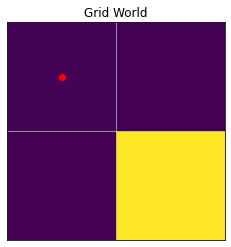

Terminal states: [(1, 1)]


World 1 

Rewards
----------------------
|   -1 |   -1 |   -1 |
----------------------
|    0 | -100 |  100 |
----------------------


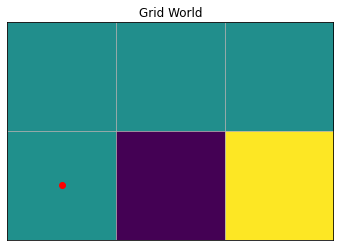

Terminal states: [(1, 1), (1, 2)]


World 2 

Rewards
-------------------------------------------------------------------------------------
|   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |
-------------------------------------------------------------------------------------
|   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |
-------------------------------------------------------------------------------------
|   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |   -1 |
-------------------------------------------------------------------------------------
|    0 | -100 | -100 | -100 | -100 | -100 | -100 | -100 | -100 | -100 | -100 |  100 |
-------------------------------------------------------------------------------------


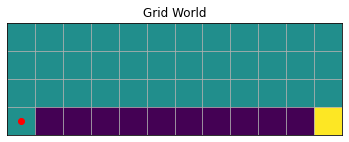

Terminal states: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11)]


World 3 

Rewards
------------------------------------------------------------------------------
|   -1 |   -1 |   -1 | -100 |   -1 |   -1 |   -1 | -100 |   -1 |   -1 |   -1 |
------------------------------------------------------------------------------
|   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 |
------------------------------------------------------------------------------
|   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 |
------------------------------------------------------------------------------
|    0 | -100 |   -1 |   -1 |   -1 | -100 |   -1 |   -1 |   -1 | -100 |  100 |
------------------------------------------------------------------------------


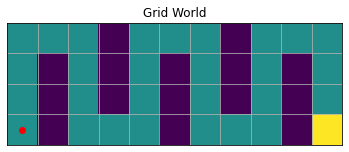

Terminal states: [(0, 3), (0, 7), (1, 1), (1, 3), (1, 5), (1, 7), (1, 9), (2, 1), (2, 3), (2, 5), (2, 7), (2, 9), (3, 1), (3, 5), (3, 9), (3, 10)]


World 4 

Rewards
-------------------------------------------------------------------------------------
|    0 |-1.04 |-1.13 |-1.31 |-1.51 |-1.64 |-1.68 |-1.84 |-2.42 |-3.45 |-4.52 |-4.98 |
-------------------------------------------------------------------------------------
|-1.02 |-1.09 | -1.3 | -1.7 |-2.16 | -2.4 |-2.31 |-2.18 |-2.44 |-3.22 |-4.12 |-4.51 |
-------------------------------------------------------------------------------------
|-1.04 |-1.16 | -1.5 |-2.16 |-2.91 |-3.28 |-3.01 |-2.48 |-2.29 |-2.62 |-3.17 |-3.42 |
-------------------------------------------------------------------------------------
|-1.05 |-1.19 | -1.6 |-2.37 |-3.27 | -3.7 |-3.34 |-2.57 |-2.03 |-1.98 |-2.18 | -2.3 |
-------------------------------------------------------------------------------------
|-1.06 |-1.18 |-1.53 | -2.2 | -3.0 |-3.41 |-3.11 |-2.38 |-1

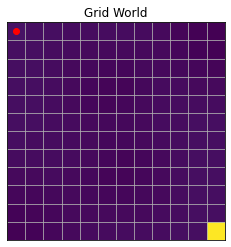

Terminal states: [(11, 11)]


World 5 

Rewards
-----------------------------------------------------------------------
|    0 | -2.8 | -4.0 | -4.6 | -5.8 | -3.5 | -5.6 | -1.1 | -0.4 | -6.2 |
-----------------------------------------------------------------------
| -2.1 | -4.7 | -4.3 | -0.7 | -9.3 | -9.1 | -9.8 | -1.7 | -2.2 | -1.3 |
-----------------------------------------------------------------------
| -0.2 | -2.0 | -5.4 | -2.2 | -8.8 | -3.6 | -8.6 | -0.6 | -4.8 | -5.9 |
-----------------------------------------------------------------------
| -7.4 | -2.3 | -5.4 | -4.3 | -9.8 | -3.8 | -3.9 | -3.8 | -0.6 | -3.2 |
-----------------------------------------------------------------------
| -6.4 | -5.6 | -3.0 | -9.4 | -3.3 | -3.3 | -7.9 | -8.7 | -6.8 | -6.4 |
-----------------------------------------------------------------------
| -4.3 | -5.6 | -0.1 | -9.0 | -7.9 | -8.4 | -3.5 | -7.5 | -5.3 | -7.6 |
-----------------------------------------------------------------------
| -8.4 | -8.9 | 

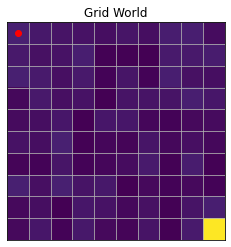

Terminal states: [(9, 9)]


World 6 

Rewards
-------------------------------------------
|    0 | -100 | -100 |   -1 |   -1 |   -1 |
-------------------------------------------
|   -1 |   -1 |   -1 | -100 |   -1 |  -10 |
-------------------------------------------
| -100 |   -1 | -100 |   -1 |   -1 |   -1 |
-------------------------------------------
| -100 |   -1 |   -1 |   -1 | -100 |   -1 |
-------------------------------------------
|   -1 |   -1 | -100 |   -1 | -100 |   -1 |
-------------------------------------------
| -100 | -100 |   -1 |   -1 |  100 |   -1 |
-------------------------------------------


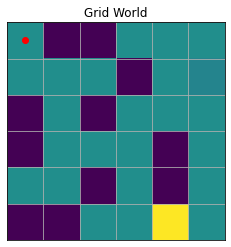

Terminal states: [(0, 1), (0, 2), (1, 3), (2, 0), (2, 2), (3, 0), (3, 4), (4, 2), (4, 4), (5, 0), (5, 1), (5, 4)]


World 7 

Rewards
-------------------------------------------
|    0 | -100 | -100 |   -1 |   -1 |   -1 |
-------------------------------------------
|   -1 |   -1 |   -1 | -100 |   -1 | -100 |
-------------------------------------------
| -100 |   -1 | -100 |   -1 |   -1 |   -1 |
-------------------------------------------
| -100 |   -1 |   -1 |   -1 | -100 |   -1 |
-------------------------------------------
|   -1 |   -1 | -100 |   -1 | -100 |   -1 |
-------------------------------------------
| -100 |   -1 |   -1 | -100 |  100 |   -1 |
-------------------------------------------


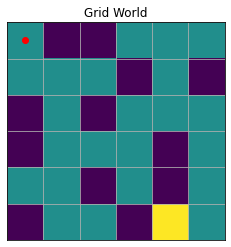

Terminal states: [(0, 1), (0, 2), (1, 3), (1, 5), (2, 0), (2, 2), (3, 0), (3, 4), (4, 2), (4, 4), (5, 0), (5, 3), (5, 4)]


World 8 

Rewards
-------------------------------------------------------------------------------------
|    0 |    0 | -100 |   -1 |   -1 | -100 |   -1 |   -1 |   -1 | -100 | -100 |   -1 |
-------------------------------------------------------------------------------------
|   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 |   -1 |   -1 |   -1 |
-------------------------------------------------------------------------------------
|   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 | -100 |   -1 | -100 | -100 |   -1 |
-------------------------------------------------------------------------------------
|   -1 |   -1 |   -1 | -100 |   -1 |   -1 |   -1 | -100 |   -1 |   -1 |   -1 | -100 |
-------------------------------------------------------------------------------------
|   -1 | -100 |   -1 | -100 | -100 | -100 |   -1 |   -1 | -100 | -100 |   -1 |   -1 

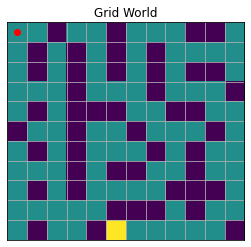

Terminal states: [(0, 2), (0, 5), (0, 9), (0, 10), (1, 1), (1, 3), (1, 5), (1, 7), (2, 1), (2, 3), (2, 5), (2, 7), (2, 9), (2, 10), (3, 3), (3, 7), (3, 11), (4, 1), (4, 3), (4, 4), (4, 5), (4, 8), (4, 9), (5, 0), (5, 3), (5, 6), (5, 10), (6, 1), (6, 3), (6, 7), (6, 9), (7, 3), (7, 5), (7, 6), (7, 9), (8, 1), (8, 3), (8, 8), (8, 9), (8, 10), (9, 5), (9, 6), (9, 7), (9, 9), (10, 1), (10, 4), (10, 5), (10, 11)]



In [10]:
# Grid worlds initialization

World = []          #   room for 10 example grid worlds

# return a list of all states which have rewards which only occur in terminal states

def get_terminal_states(grid,terminal_rewards=[-100,100]):
    TS = []
    for r in range(len(grid)):
        for c in range(len(grid[0])):
            if grid[r][c] in terminal_rewards:
                TS.append((r,c))
    return TS

# World[0]: simple test case, two paths



World.append( GridWorld( [ [0,-1,], 
                        [-1,100] 
                      ], 
                      (0,0), 
                      [(1,1)] 
                    )
            )

# World[1]: short cliff walking

World.append( GridWorld( [ [-1,-1,-1], 
                        [0,-100,100] 
                      ], 
                      (1,0), 
                      [(1,1),(1,2)] 
                    )
            )

# World[2]: cliff walking from lecture

grid =                   [ [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
                           [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
                           [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
                           [0,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,100]
                         ]

World.append( GridWorld( grid, (3,0), get_terminal_states(grid) ) )


# World[3]: walking a serpentine path

grid =                [ [-1,  -1,-1,-100,-1,  -1,-1,-100,-1,  -1, -1],
                        [-1,-100,-1,-100,-1,-100,-1,-100,-1,-100, -1],
                        [-1,-100,-1,-100,-1,-100,-1,-100,-1,-100, -1],
                        [ 0,-100,-1,  -1,-1,-100,-1,  -1,-1,-100,100]
                      ]

World.append( GridWorld( grid, (3,0), get_terminal_states(grid) ) )

# World[4]: This one has six "valleys" and the agent has to find the best path around them.

def makeGridTerrain(num_rows,num_cols,Valleys):

    W = np.zeros((num_rows,num_cols))
    W.fill(-1)
    
    # Use the PDF of a 2D normal and subtract from the default -1

    for V in Valleys:  
        var = multivariate_normal(mean=V[0], cov=[[V[1],0],[0,V[2]]])
        for r in range(num_rows):
            for c in range(num_cols):
                W[r][c] -=  var.pdf([r,c])*V[3]*10

    # add start and goal states
    
    W[0][0] = 0
    W[num_rows-1][num_cols-1] = 100
    
    return np.around(W,2)

# List of valleys, each a tuple (mean = center, std_rows, std_cols, depth)

Valleys = [([0,11], 4, 4, 10),
           ([11,0], 5, 5, 10),
           ([3,5], 3, 3, 5),
           ([8,6], 3, 3, 5),
          ]


World.append( GridWorld( makeGridTerrain(12,12,Valleys), (0,0), [(11,11)] ) )
               

# World[5]: This one is completely random!

seed(0); grid = np.around(10*rand(10,10)-10,1); grid[0][0] = 0; grid[9][9] = 100

World.append( GridWorld( grid, (0,0), [(9,9)]) )

# World[6]: Simple maze

grid =                [[-1, -100, -100, -1, -1, -1], 
                       [-1, -1, -1, -100, -1, -10], 
                       [-100, -1, -100, -1, -1, -1], 
                       [-100, -1, -1, -1, -100, -1], 
                       [-1, -1, -100, -1, -100, -1], 
                       [-100, -100, -1, -1, 100, -1]
                      ]

World.append( GridWorld( grid, (0,0), get_terminal_states(grid) ) )

# World[6]: More difficult maze

grid =                [[-1, -100, -100, -1, -1, -1], 
                       [-1, -1, -1, -100, -1, -100], 
                       [-100, -1, -100, -1, -1, -1], 
                       [-100, -1, -1, -1, -100, -1], 
                       [-1, -1, -100, -1, -100, -1], 
                       [-100, -1, -1, -100, 100, -1]
                      ]

World.append( GridWorld( grid, (0,0), get_terminal_states(grid) ) )


# World[7]: Hard maze

grid =                [[ -1,  0,  -100,-1,  -1, -100,  -1,  -1,  -1,   -100, -100,  -1 ], 
                       [ -1, -100,  -1, -100,  -1, -100,  -1, -100,  -1,  -1,  -1,  -1 ], 
                       [ -1, -100,  -1, -100,  -1, -100,  -1, -100,  -1, -100, -100,  -1 ], 
                       [ -1,  -1,  -1, -100,  -1,  -1,  -1, -100,  -1,  -1,  -1, -100 ], 
                       [ -1, -100,  -1, -100,   -100, -100,  -1,  -1, -100, -100,  -1,  -1 ], 
                       [-100,  -1,  -1, -100,  -1,  -1, -100,  -1,  -1,  -1, -100,  -1 ], 
                       [ -1, -100,  -1, -100,  -1,  -1,  -1, -100,  -1, -100,  -1,  -1 ], 
                       [ -1,  -1,  -1, -100,  -1, -100, -100,  -1,  -1, -100,  -1,  -1 ], 
                       [ -1, -100,  -1, -100,  -1,  -1,  -1,  -1, -100, -100,   -100,  -1 ], 
                       [ -1,  -1,  -1,  -1,  -1, -100, -100, -100,  -1, -100,  -1,  -1 ], 
                       [ -1, -100,  -1,  -1, -100,  100,  -1,  -1,  -1,  -1,  -1, -100 ]
                      ]

World.append( GridWorld( grid, (0,0), get_terminal_states(grid) ) )
                     

# test

for N in range(len(World)):
    print("\nWorld",N,'\n')
    World[N].print_rewards()
    World[N].display_heat_map()
    print("Terminal states:",World[N].terminal_states)
    print()

## Problem Six (5 pts)

The first task in this set of problems is to create a dictionary which determines the allowable
set of actions in each state, and a `goto` function which tells how an action moves to a new state.  

A state is simply a pair `(row,col)` in the grid. 

#### Part A

Actions are

       Moves     = ['U','R','L','D']    =    Up, Right, Left, Down
       
Clearly, you can not move outside the allowable indices for the given grid. 

Hint: Create a default dictionary which returns Moves (meaning, any move is allowed) and
then add the special cases for corners and edges of the grid. You can get the dimensions
of the grid using `W.num_rows` and `W.num_cols`. A default dictionary may be created
as follows:

    Dictionary = defaultdict((lambda : <default-value>))

In [11]:
# Actions for each state
# These are lists so can use np.random.choice for exploration 

Moves     = ['U','R','L','D']
    
def initialize_Actions(W):
    movedict = defaultdict((lambda : Moves))
    for x in range(W.num_cols):
        for y in range(W.num_rows):
            movelist = Moves.copy()
            if y-1 < 0:
                movelist.remove('U')
            if x+1 >= W.num_cols:
                movelist.remove('R')
            if x-1 < 0:
                movelist.remove('L')
            if y+1 >= W.num_rows:
                movelist.remove('D')
            movedict.update({(y, x):movelist})
    
    return movedict


# test for several values of N
N = 1
World[N].print_rewards()
A = initialize_Actions(World[N])

print(A[(1,2)])

A

Rewards
----------------------
|   -1 |   -1 |   -1 |
----------------------
|    0 | -100 |  100 |
----------------------
['U', 'L']


defaultdict(<function __main__.initialize_Actions.<locals>.<lambda>()>,
            {(0, 0): ['R', 'D'],
             (1, 0): ['U', 'R'],
             (0, 1): ['R', 'L', 'D'],
             (1, 1): ['U', 'R', 'L'],
             (0, 2): ['L', 'D'],
             (1, 2): ['U', 'L']})

#### Part B

Now you must write a function which determines the next state, given the current state and
the action.  An example is shown in the test.  Do not bother with error checking, as this
will only be called on states and moves which have been checked with a dictionary `A` created
in Part A. 

In [12]:
# state transitions -- no error checking, will only be called on legal moves

def goto_state(s,a):
    goto = list(s).copy()
    if a == 'U':
        goto = (goto[0] - 1, goto[1])
    if a == 'R':
        goto = (goto[0], goto[1] + 1)
    if a == 'L':
        goto = (goto[0], goto[1] - 1)
    if a == 'D':
        goto = (goto[0] + 1, goto[1])
    return tuple(goto)


# test

for m in Moves:
    print(goto_state((2,3),m))

(1, 3)
(2, 4)
(2, 2)
(3, 3)


## Problem Seven (5 pts)

The next task in this set of problems is to create the Q-Table which records the current best
estimate of the strategy, as discussed in lecture. As you can see from the test, the Q-Table
starts with random values in the range -10 .. 0 for all legal moves in non-terminal states.
In order for the calculation of Q-values to be correct, terminal states must have 0.0 for all moves (since
no move will ever be taken from a terminal state). 

Thus, the Q-Table is effectively a 3D array (rows, columns, and moves) but we will implement
this as a dictionary with keys `(state,move)` = `((row,col),move)` mapped to Q-values (floats). 

Hint: Use `random()` with suitable arithmetic operations to expand and shift from the range [0..1] to
the range [-10..0].  Do not worry about what states are terminal, as the Q-values will never
be used!


In [115]:
# Q-Table is dictionary with keys (state,move) = ((row,col),move) mapped to Q-values

# Initialize non-terminal states with random default values in range -10..0; but
# must initialize all terminal states with 0.0 or else Q-values will not be accurate!

def initialize_Q_table(W,A):
    qtable = defaultdict((lambda : 0))
    for s in A:
        if s in W.terminal_states:
            for m in A[s]:
                qtable.update({(s,m):0})
        else:
            for m in A[s]:
                qtable.update({(s,m):random()*-10})
    return qtable


def print_Q_table(W,A,Q):
    print("Q-Table")
    width = 6
    precision = 4

    hrule = ('---------'*W.num_cols)+'-'

    print(hrule)
    for r in range(W.num_rows):
        for move in ['U','L','R','D']:
            for c in range(W.num_cols):
                if (r,c) in W.terminal_states:
                    print('|  '+(" "*width),end='')
                elif move in A[(r,c)]:
                    print('|'+move+':'+f"{np.around(Q[((r,c),move)],3):{width}.{precision}}",end='')
                else:
                    print('|'+move+':'+(" "*width),end='')

            print('|')
        print(hrule)

# test -- try for several values of N

seed(0)
N = 1
W = World[N]
A = initialize_Actions(World[N])
Q = initialize_Q_table(W,A)
print_Q_table(W,A,Q)

Q-Table
----------------------------
|U:      |U:      |U:      |
|L:      |L:-6.459|L:-8.918|
|R:-5.488|R:-4.237|R:      |
|D:-7.152|D:-4.376|D:-9.637|
----------------------------
|U:-6.028|        |        |
|L:      |        |        |
|R:-5.449|        |        |
|D:      |        |        |
----------------------------


## Problem Eight (5 pts)

Now we must create functions to determine the best allowable move, given A, Q, and the state,
and write an epsilon-greedy version of the strategy `Pi`. 

The best move is simply the allowable move from the current state with the maximum Q-value. 
Return the move as a character 'U', 'R', etc. 

The epsilon-greed strategy will choose a random move from those allowable in the current
state with probability `epsilon` or the best move with probability `1-epsilon`. 

In [120]:
# Strategy code for epsilon-greedy Pi

# find move with best Q-value in state s
def best_move(A,Q,s):
    best = ''
    score = -1000
    for m in A[s]:
        if score < Q[m]:
            score = Q[m]
            best = m
    return best


# epsilon-greedy strategy

def Pi(A,Q,s,epsilon):
    return choice([choice(A[s]), best_move(A,Q,s)], p=[epsilon, 1-epsilon])

 

In [127]:
# Tests:   run this cell repeatedly to test for N == 1 two cells up
# Note: my random generator appears to be different from the professor's;
# the following results are based on my own values

print(best_move(A,Q,(0,0)))   # 'R' 
print(best_move(A,Q,(0,2)))   # 'L' 
print()
print(Pi(A,Q,(1,0),0.0))    # 'U' 
print(Pi(A,Q,(1,0),0.5))    # should give 'U' about 3x as often as 'R'
print(Pi(A,Q,(1,0),1.0))    # should give approximately same number of 'U' and 'R'

R
L

U
U
U


In [128]:
# Pretty-printing code for Strategy
# Uses: best_move
        
def print_strategy(W,A,Q):
    print("Strategy Pi")
    width = 6
    precision = 4

    hrule = ('------'*W.num_cols)+'-'

    print(hrule)
    for r in range(W.num_rows):
        for k in range(3):
            for c in range(W.num_cols):
                if (r,c) in W.terminal_states:
                    print('|     ',end='')
                else:
                    move = best_move(A,Q,(r,c))
                    if k == 0:
                        if move in ['L','R']:
                            print('|     ',end='')
                        elif move == 'U':
                            print('|  ^  ',end='')
                        else:
                            print('|  |  ',end='')
                    elif k == 1:
                        if move =='R':
                            print('|---->',end='')
                        elif move == 'L':
                            print('|<----',end='')
                        else:
                            print('|  |  ',end='')                        
                    else: 
                        if move in ['L','R']:
                            print('|     ',end='')
                        elif move == 'D':
                            print('|  v  ',end='')
                        else:
                            print('|  |  ',end='')                   
            print('|')
        print(hrule)
    

## Problem Nine (15 pts)

In this problem we will create the framework for running multiple trials for the agent
to learn how to solve the GridWorld problem of maximizing rewards. 

There are several parameters of interest, as explained in lecture:

- epsilon =  for epsilon-greedy strategy, probability of exploration by random move

- lam = exponential decrease in epsilon    (can not use "lambda" because that is a keyword in Python)

- num_trials = number of random trials in this experiment

(We also thought about the use of a "learning rate" parameter `alpha` and a "discount" `gamma` for future rewards, but these seemed to only be a disadvantage in this simple GridWorld scenario.)


In [1]:
# Q-Algorithm code


def run_experiment(N,epsilon=0.25,lam=1.0,num_trials=1000,display=False):
       
    # initialize grid world N
    
    N = []
       
    # use a seed to help with comparing results
    seed(0)
    
    # initialize A
    
    # initialize Q
    
    # Now run num_trials different trials. For each, 
    
            # initialize the current state s to the start state
        
            # while s is not a terminal state
            
                #  determine the action a from s using the policy Pi            
                #  determine the next state s1 given the action a
                #  determine the reward and the best move in s1
                #  update Q-Table with the new Q-value for current state s = sum of reward in s1 and 
                #       Q-value of best move in s1;
                
                #  update epsilon, reduced in each successive move by lam (if lam < 1 this means
                #      you will explore less and less as the trial goes on)
                #  update current state to s1
                

    
        
    # calculate the cumulative reward of the path given by the strategy implied by the Q-table
    # This will get into an infinite loop if the path has cycles! To check for cycles,
    # add all states in the path into a set, and for each new state in the path, if
    # it is already in the set, you have a cycle and a cumulative reward is meaningless.
    # set a flag  cycle = True   if a cycle is found. 
    
 
        
    # show all the data structures if you want
    
    if display:    
        W.display_heat_map()
        print()
        W.print_rewards()
        print()
        print_Q_table(W,A,Q)   
        print()
        print_strategy(W,A,Q)
        print()
    
    # if there is a cycle, return 0, else return the cumulative reward

# test

#print("Reward:",run_experiment(2,num_trials=200, display=True))

## Problem Ten (20 pts)

Now we will reap the benefit of the previous problems and find out how well the
Q-Algorithm does to learn paths in these grid worlds!

For each of the 9 grid world examples, play around with the parameters

          epsilon,    lam,       num_trials
          
to answer the following question:

      What parameters will solve the problem in the fewest number of trials?
      
"Solving" the problem means learning a "steady-state" strategy, meaning that if you increase
the number of trials, the strategy does not change.  The agent may accidentally hit on 
an optimal strategy, but continuing to search may "unlearn" the solution. The system
can only be said to have learned the optimal strategy only if it does not change as the number
of trials is increased. 

In order to help you with your experiments, the following function is provided, which
will plot the rewards for a number of trials between two bounds. The best way to proceed is to
try single experiments with various parameters as shown at the end of the previous cell, 
and then confirm your understanding with the `plot_rewards` function. The example
shows how to determine when the problem has been solved. 

Your solution to this problem is a presentation of the experiments you performed, plus your analysis. 
Be sure to test various values for epsilon and lam. You must do all 9 examples. 

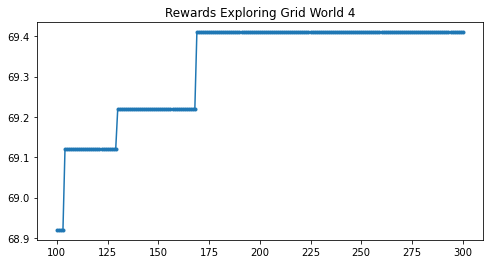

Reward: 69.41
Steady state found at 169 trials.


In [18]:
# Plotting the rewards to find smallest number of trials which produce a steady-state maximum reward


def plot_rewards(N,lower_bound,upper_bound,epsilon=0.25,lam=1.0):

    X = range(lower_bound,upper_bound+1)

    Y = [run_experiment(N,epsilon=epsilon,lam=lam,num_trials=k,display=False) for k in X]

    plt.figure(figsize=(8,4))
    plt.title('Rewards Exploring Grid World '+str(N))
    plt.plot(X,Y)
    plt.scatter(X,Y,marker='.')
    plt.show()

    print("Reward:",Y[-1])
    
    # under assumption that steady state was reached by the upper_bound, 
    # find the first time that value was found in this range
    
    for k in range(len(Y)-1,-1, -1):
        if Y[k] < Y[-1]:
            print("Steady state found at",X[k+1],"trials.")
            break

# example

plot_rewards(4,100,300)
